In [16]:
# %load withholding.py
%matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float('nan')])

def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert(np.sum(activations) == row.number_activations or row.error)
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d['attacker_compute'] = rcompute[0]
    d['attacker_relative_activations'] = ractivations[0]
    d['attacker_relative_reward'] = rreward[0]
    d['attacker_gain'] = rreward[0] - compute[0]
    d['attacker_efficiency'] = rreward[0] / compute[0]
    return d

df=df.join(df.apply(expand, axis=1, result_type='expand'))

In [31]:
d = df[df.protocol == "george"]
d = d[(d.incentive_scheme == 'constant') | (d.incentive_scheme == 'discount')]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'machine_duration_s', 'error', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_efficiency'],
      dtype='object')

In [32]:
d.pivot(index=['attacker_compute', 'k'], columns=['strategy', 'incentive_scheme'], values='attacker_efficiency')

strategy             private-selfish-alt           private-selfish            \
incentive_scheme                constant  discount        constant  discount   
attacker_compute k                                                             
0.10             1              0.351289  0.351289        0.351010  0.351010   
                 2              0.640835  0.640835        0.245159  0.245159   
                 4              0.856057  0.753655        0.161062  0.153958   
                 8              0.927420  0.859641        0.127339  0.118430   
                 16             0.963527  0.924743        0.132407  0.121847   
                 32             0.985870  0.965211        0.164789  0.152480   
                 64             0.994366  0.983869        0.243839  0.227196   
                 128            1.000024  0.994616        0.437062  0.414387   
0.20             1              0.630391  0.630391        0.630391  0.630391   
                 2              0.770924  0.770924        0.518934  0.518934   
                 4              0.921938  0.848108        0.407707  0.387687   
                 8              0.959919  0.912072        0.395907  0.357067   
                 16             0.978129  0.950019        0.453318  0.400901   
                 32             0.986365  0.971103        0.631638  0.570237   
                 64             0.994867  0.987227        0.879327  0.832381   
                 128            0.997288  0.993367        1.083825  1.065878   
0.25             1              0.749269  0.749269        0.749684  0.749684   
                 2              0.838698  0.838698        0.657941  0.657941   
                 4              0.950423  0.890448        0.555617  0.530040   
                 8              0.972672  0.933538        0.555875  0.499977   
                 16             0.984472  0.960648        0.668004  0.588172   
                 32             0.994200  0.981259        0.891297  0.815011   
                 64             0.995435  0.988644        1.115723  1.076600   
                 128            0.995550  0.992105        1.225093  1.209342   
0.33             1              0.919100  0.919100        0.921500  0.921500   
                 2              0.945191  0.945191        0.850010  0.850010   
                 4              0.984236  0.947647        0.790530  0.762477   
                 8              0.991302  0.965090        0.863361  0.793304   
                 16             0.994123  0.976400        1.052230  0.963329   
                 32             0.994861  0.984679        1.281023  1.230599   
                 64             0.998177  0.992737        1.392565  1.374080   
                 128            0.997697  0.994938        1.445282  1.438019   
0.40             1              1.061049  1.061049        1.061841  1.061841   
                 2              1.041945  1.041945        1.009051  1.009051   
                 4              1.004881  0.986220        0.978597  0.955981   
                 8              1.002669  0.987011        1.132270  1.084114   
                 16             0.999587  0.987079        1.388141  1.370061   
                 32             0.997234  0.989403        1.574065  1.601805   
                 64             1.000208  0.995894        1.632529  1.657390   
                 128            1.000019  0.997708        1.654539  1.668251   
0.45             1              1.149424  1.149424        1.149243  1.149243   
                 2              1.111876  1.111876        1.108760  1.108760   
                 4              1.019244  1.012773        1.103404  1.088378   
                 8              1.009771  1.001223        1.288296  1.270852   
                 16             1.004740  0.996169        1.535064  1.566898   
                 32             0.999747  0.993537        1.684524  1.727073   
                 64             1.000453  0.996733        1.759685  1.785493   


<IPython.core.display.Javascript object>


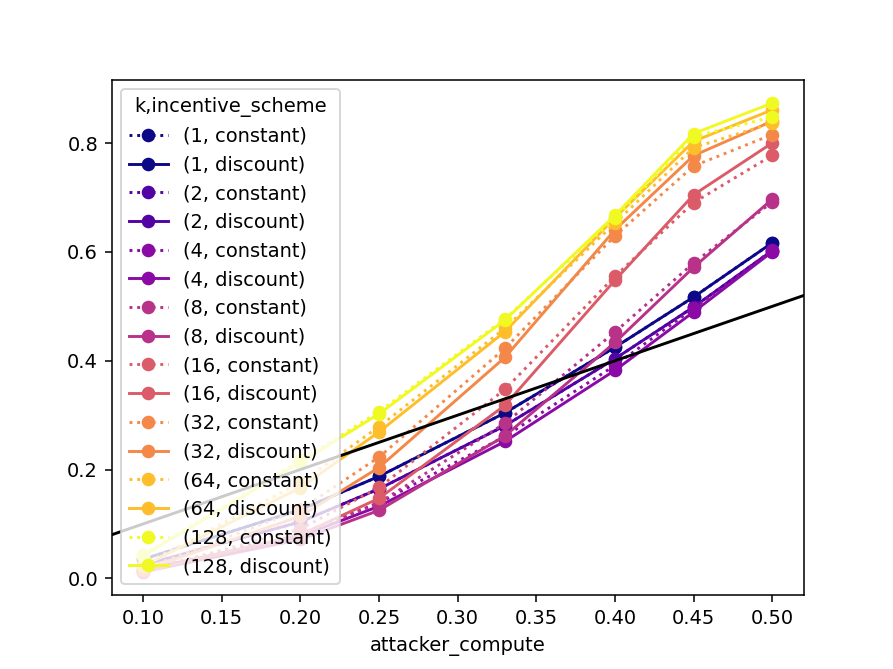

In [36]:
# compare same strategy for incentive schemes
dd = d[d.strategy == 'private-selfish']
dd = dd.pivot(index=['attacker_compute'], columns=['k', 'incentive_scheme'], values='attacker_relative_reward')
dd = dd[sorted(dd.columns)]
line_style = [ 'o-' if proto == 'discount' else 'o:' for (k, proto) in  dd.columns]
k = np.unique([ k for (k, proto) in dd.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in dd.columns ]
line_colors
p = dd.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')

<IPython.core.display.Javascript object>


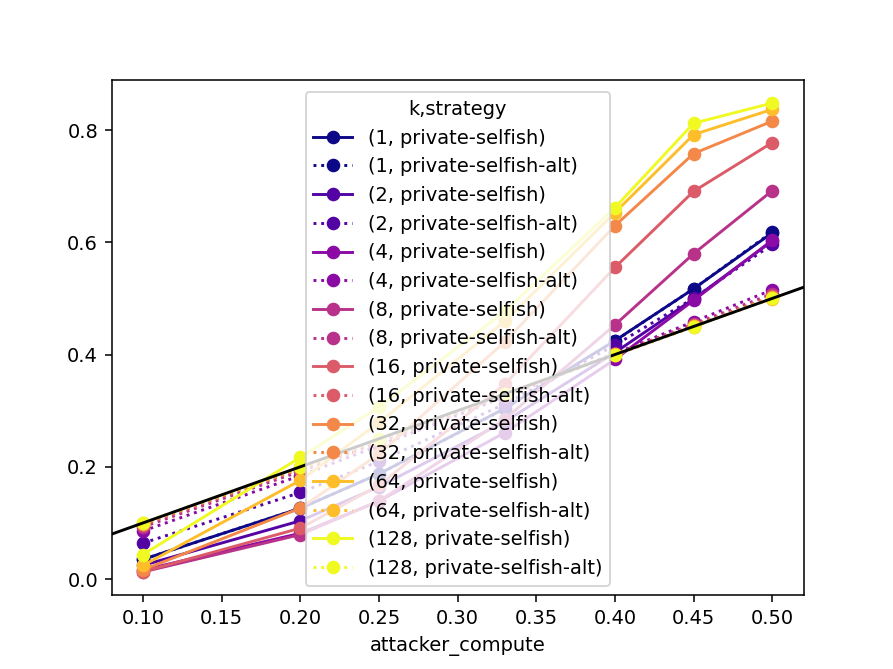

In [37]:
# does numerical implementation line up with non-numerical implementation of policiy?
dd = d
dd = dd[dd['protocol']=='george']
dd = dd[(dd['strategy']=='private-selfish') | (dd['strategy']=='private-selfish-alt')]
dd = dd[dd['incentive_scheme']=='constant']
dd = dd.pivot(index=['attacker_compute'], columns=['k', 'strategy'], values='attacker_relative_reward')
dd = dd[sorted(dd.columns)]
line_style = [ 'o-' if proto == 'private-selfish' else 'o:' for (k, proto) in  dd.columns]
k = np.unique([ k for (k, proto) in dd.columns])
cmap = plt.cm.get_cmap('plasma', len(k))
colormap = { k: cmap(i) for (i, k) in enumerate(k) }
line_colors = [ colormap[k] for (k, proto) in dd.columns ]
line_colors
p = dd.plot(style=line_style, color=line_colors)
p.axline([.1, .1], [.5, .5], color='black')
# it does not!